# 1. 비즈니스 목표
목표 :
상품 이미지에 태그(베스트, 신상품, 세일 등)를 부착하는 것이 고객의 관심을 끌 수 있는지 A/B 테스트를 통해 확인한다.

# 2. 문제 정의
고객 그룹을 50:50으로 나누어서 한 그룹(test 그룹)에는 각 상품에 세일 기간, Top10, New 등의 태그를 부착한다.

다른 그룹(control)에는 태그 부착 없이 상품 자체만 보여주고, 일정 기간동안 데이터를 축적시킨다.

일정 기간이 지난 후, test 그룹과 control 그룹 간, 클릭률이 유의미한 차이가 있는지 통계적으로 검증한다.

* 요약
    * 프로덕트: 이커머스 상품 리스트 페이지
    * 테스트할 새로운 기능: 상품 이미지에 태그 (베스트, 신상품, 세일 등)

    * control 그룹: 기존안 (상품 이미지 태그 미포함)
    * test 그룹: 개선안 (상품 이미지 태그 포함)

* 목표 지표: CTR (상품클릭수 / 상품조회수)
* 가드레일 지표: 상품조회수

-> 만약 test 그룹의 CTR이 상승했는데, 상품조회수가 하락해서 상승한 것이면 의도한 바가 아니므로, 상품조회수를 가드레일 지표로 두고 CTR과 함께 분석한다.

분석해볼 내용
1) control군과 test군의 목표 지표에 유의미한 차이가 있었는가?
2) control군과 test군의 가드레일 지표가 차이가 있는가? 떨어지지 않았는가?
3) 지표들에 연령대별 차이가 있는지 추가 분석


# 3. 사용할 데이터
test 그룹, control 그룹을 나누어 일정 기간동안 실험을 했다고 가정하고, 임의로 생성한 모의 데이터를 사용한다.

In [ ]:
# 가상 데이터 생성
import pandas as pd
import numpy as np
from scipy.stats import expon

np.random.seed(42)

# 50000명 데이터 가정
num_users = 50000
user_ids = range(1, num_users + 1)

# 50000명 중 50%를 test 그룹, 50%를 control 그룹으로 나누기
test_groups = np.random.choice(['control', 'test'], size=num_users, p=[0.5, 0.5])

# 나이대 그룹 생성 (10대, 20대, 30대, 40대)
age_groups = np.random.choice(['10s', '20s', '30s', '40s'], size=num_users, p=[0.15, 0.35, 0.35, 0.15])

user_info_df = pd.DataFrame({
    'user_id': user_ids,
    'test_group': test_groups,
    'age_group': age_groups
})

# 조회수, 클릭수 생성
views = expon.rvs(scale=1000, size=num_users).astype(int)
views = np.clip(views, 0, 10000)
base_ctr = expon.rvs(scale=0.05, size=num_users)
base_ctr = np.clip(base_ctr, 0, 1)

# CTR 조정
# test 그룹에 25%의 CTR 상승 적용
ctr_adjustment = np.ones(num_users)
ctr_adjustment[test_groups == 'test'] *= 1.25

# 나이대별로 CTR 조정 (20대, 30대 사용자에게 추가 상승 적용)
ctr_adjustment[(test_groups == 'test') & (age_groups == '20s')] *= 1.1
ctr_adjustment[(test_groups == 'test') & (age_groups == '30s')] *= 1.1

adjusted_ctr = base_ctr * ctr_adjustment
adjusted_ctr = np.clip(adjusted_ctr, 0, 1)

# 클릭수 계산
# 클릭수는 조회수에 CTR을 곱한 값으로 계산하고, 최대 5000으로 제한
clicks = (views * adjusted_ctr).astype(int)
clicks = np.clip(clicks, 0, 5000)

# AB 테스트 데이터프레임 생성
ab_test_df = pd.DataFrame({
    'user_id': user_ids,
    'views': views,
    'clicks': clicks
})

# 데이터 저장
user_info_df.to_csv('user_info_data.csv', index=False)
ab_test_df.to_csv('ab_test_data.csv', index=False)

## 데이터 확인 및 전처리

In [ ]:
user_info_df.head()

,user_id,test_group,age_group
0,1,control,30s
1,2,test,20s
2,3,test,20s
3,4,test,30s
4,5,control,20s


In [ ]:
ab_test_df.head()

,user_id,views,clicks
0,1,869,3
1,2,748,45
2,3,432,47
3,4,679,67
4,5,454,41


In [ ]:
data = pd.merge(user_info_df, ab_test_df, on='user_id')
data.head()

,user_id,test_group,age_group,views,clicks
0,1,control,30s,869,3
1,2,test,20s,748,45
2,3,test,20s,432,47
3,4,test,30s,679,67
4,5,control,20s,454,41


In [ ]:
data['ctr'] = data['clicks'] / data['views']
data.head()

,user_id,test_group,age_group,views,clicks,ctr
0,1,control,30s,869,3,0.003452
1,2,test,20s,748,45,0.060160
2,3,test,20s,432,47,0.108796
3,4,test,30s,679,67,0.098675
4,5,control,20s,454,41,0.090308


# 3. 가설 확인

## 1) control군과 test군의 목표 지표에 유의미한 차이가 있었는가?

In [ ]:
data.head()

,user_id,test_group,age_group,views,clicks,ctr
0,1,control,30s,869,3,0.003452
1,2,test,20s,748,45,0.060160
2,3,test,20s,432,47,0.108796
3,4,test,30s,679,67,0.098675
4,5,control,20s,454,41,0.090308


In [ ]:
# 그룹별 평균 CTR 확인
display(data.groupby('test_group')['ctr'].mean())

test_group
control    0.04784
test       0.06475
Name: ctr, dtype: float64

In [ ]:
test_ctr = data.query('test_group == "test"')['ctr'].mean()
control_ctr = data.query('test_group == "control"')['ctr'].mean()

print(f'test_ctr: {test_ctr:.2%}')
print(f'control_ctr: {control_ctr:.2%}')
print(f'uplift%: {test_ctr/control_ctr - 1:.2%}')

test_ctr: 6.47%
control_ctr: 4.78%
uplift%: 35.35%


수치상으로 test 그룹의 CTR이 conrol 그룹에 비해 35.35% 향상된 것 확인 가능

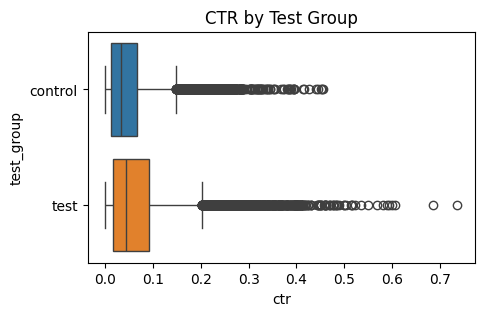

In [ ]:
# 그룹별 CTR 박스플롯 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(5,3))
sns.boxplot(y='test_group', x='ctr', data=data, hue='test_group')
plt.title('CTR by Test Group')
plt.show()

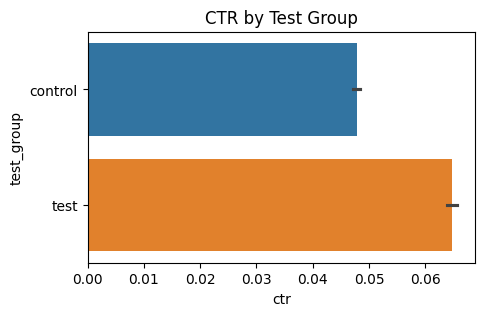

In [ ]:
# 그룹별 CTR 막대그래프 시각화
plt.figure(figsize=(5,3))
sns.barplot(y='test_group', x='ctr', data=data, hue='test_group')
plt.title('CTR by Test Group')
plt.show()

#### 결론 : test 그룹의 CTR이 수치상/시각적으로 상승한 것이 확인 가능하나, 아직 통계적으로 유의미하게 상승한 것인지는 검정 필요

## 2) control군과 test군의 가드레일 지표가 차이가 있는가? 떨어지지 않았는가?

In [ ]:
# 가드레일 지표를 'views'로 설정하였으므로, 그룹별 views 평균 확인
data.groupby('test_group')['views'].mean()

test_group
control     999.176506
test       1011.922917
Name: views, dtype: float64

In [ ]:
# 그룹별 평균 views, clicks, ctr 확인
data.groupby('test_group')[['views','clicks','ctr']].mean()

,views,clicks,ctr
test_group,,,
control,999.176506,49.242207,0.04784
test,1011.922917,67.510562,0.06475


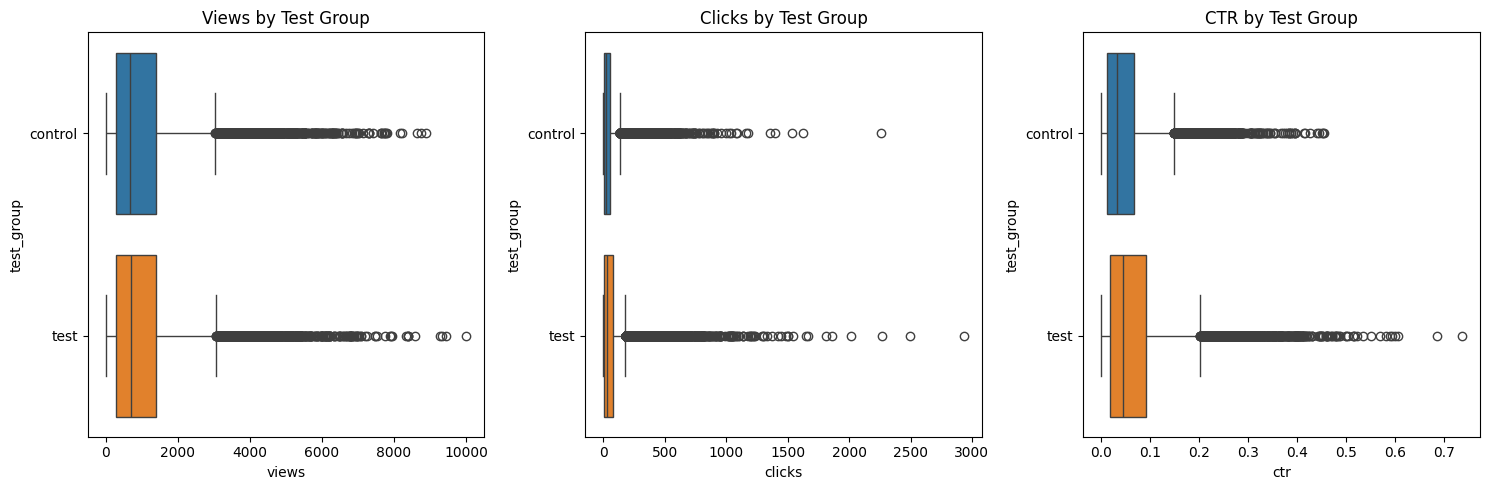

In [ ]:
# 그룹별 views, clicks, ctr 박스플롯 시각화
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.boxplot(y='test_group', x='views', data=data, hue='test_group')
plt.title('Views by Test Group')

plt.subplot(1,3,2)
sns.boxplot(y='test_group', x='clicks', data=data, hue='test_group')
plt.title('Clicks by Test Group')

plt.subplot(1,3,3)
sns.boxplot(y='test_group', x='ctr', data=data, hue='test_group')
plt.title('CTR by Test Group')

plt.tight_layout()
plt.show()

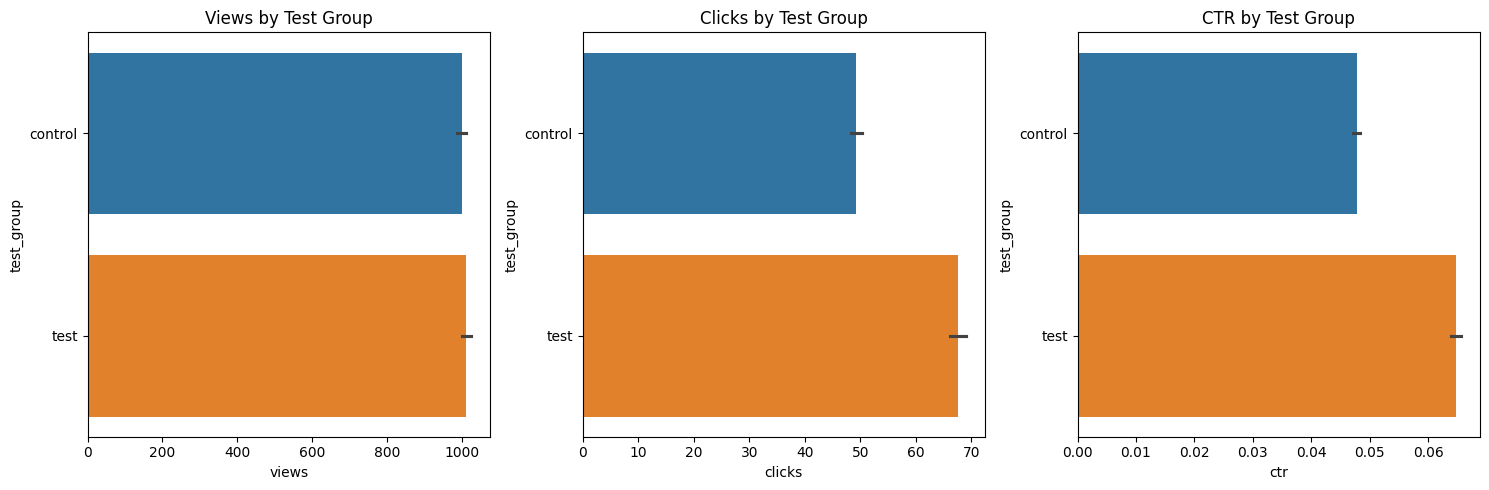

In [ ]:
# 그룹별 views, clicks, ctr 막대그래프 시각화
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.barplot(y='test_group', x='views', data=data, hue='test_group')
plt.title('Views by Test Group')

plt.subplot(1,3,2)
sns.barplot(y='test_group', x='clicks', data=data, hue='test_group')
plt.title('Clicks by Test Group')

plt.subplot(1,3,3)
sns.barplot(y='test_group', x='ctr', data=data, hue='test_group')
plt.title('CTR by Test Group')

plt.tight_layout()
plt.show()

#### 결론 : test 그룹의 CTR이 상승했는데, test 그룹의 가드레일지표(views) 또한 떨어지지 않고 상승하였으므로, 의도했던 방향과 일치함

## 3) 지표들에 연령대별 차이가 있는지 추가 분석

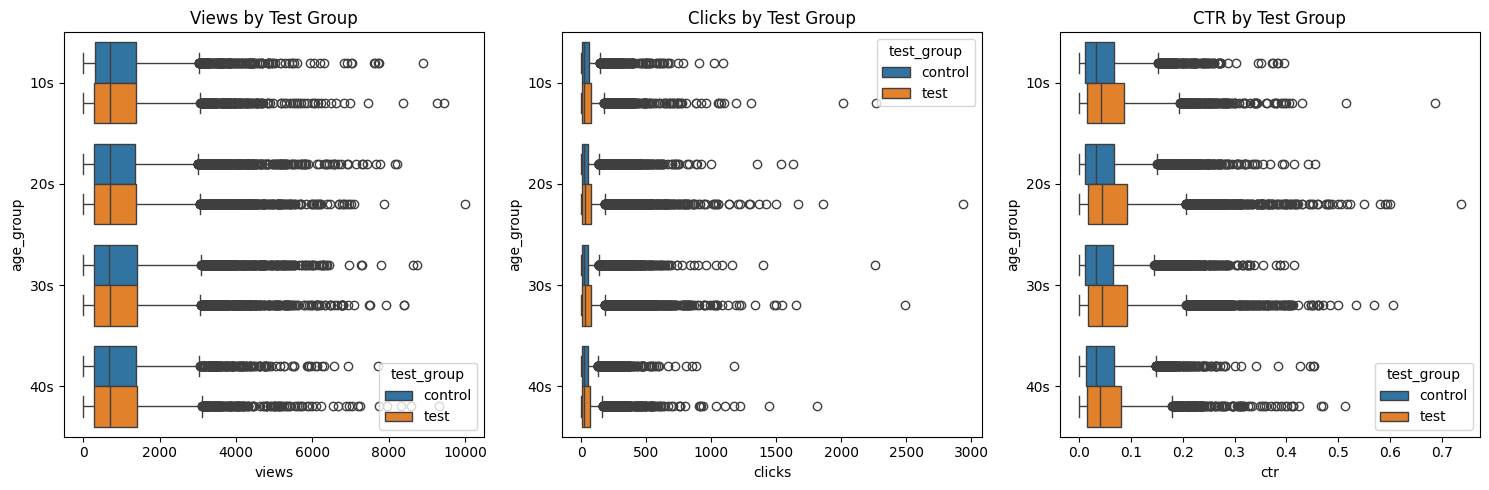

In [ ]:
# 연령대별로 CTR 차이 분석을 위해 데이터 정렬
# 연령대별 views, clicks, ctr 박스플롯 시각화
data.sort_values(['age_group','test_group'], inplace=True)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.boxplot(y='age_group', x='views', data=data, hue='test_group')
plt.title('Views by Test Group')

plt.subplot(1,3,2)
sns.boxplot(y='age_group', x='clicks', data=data, hue='test_group')
plt.title('Clicks by Test Group')

plt.subplot(1,3,3)
sns.boxplot(y='age_group', x='ctr', data=data, hue='test_group')
plt.title('CTR by Test Group')

plt.tight_layout()
plt.show()

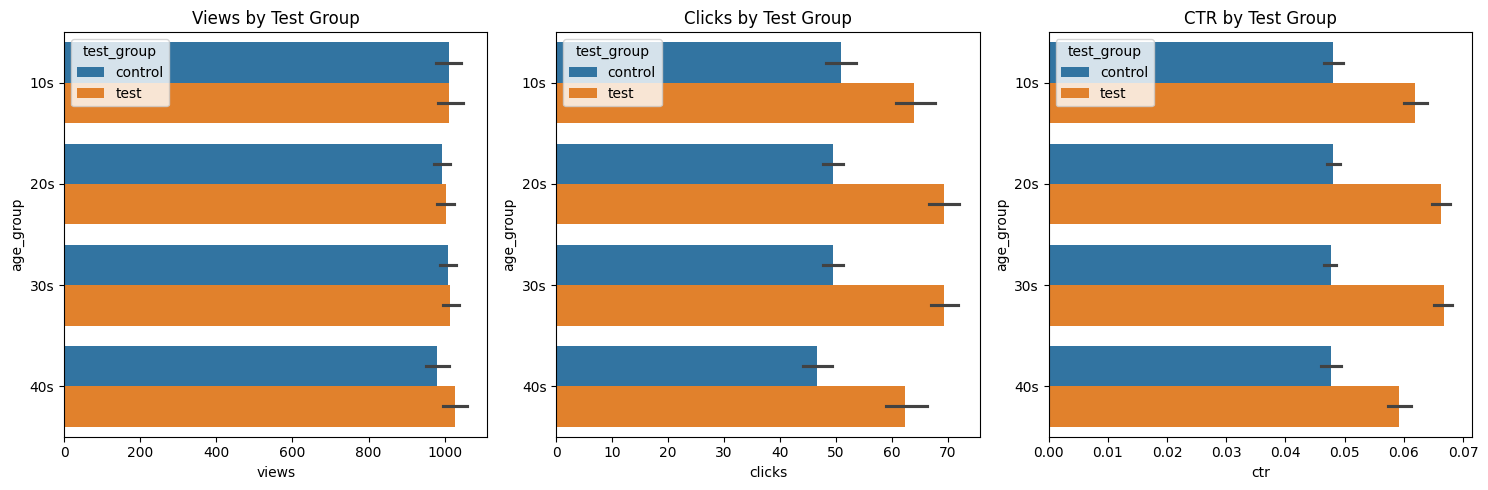

In [ ]:
# 연령대별로 CTR 차이 분석을 위해 데이터 정렬
# 연령대별 views, clicks, ctr 막대그래프 시각화
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.barplot(y='age_group', x='views', data=data, hue='test_group')
plt.title('Views by Test Group')

plt.subplot(1,3,2)
sns.barplot(y='age_group', x='clicks', data=data, hue='test_group')
plt.title('Clicks by Test Group')

plt.subplot(1,3,3)
sns.barplot(y='age_group', x='ctr', data=data, hue='test_group')
plt.title('CTR by Test Group')

plt.tight_layout()
plt.show()

#### 결론 : test그룹의 클릭수(Clicks)와 클릭률(CTR)이 2030세대에서 좀 더 크게 증가한 것 확인 가능

# 4. 가설 검정

In [ ]:
from scipy import stats

In [ ]:
# views, clicks, ctr에 대한 t-검정 수행
# 두 그룹 간의 평균 차이를 검정하여 유의미한 차이가 있는지 확인
# p-value가 0.05 미만이면 유의미한 차이가 있다고 판단
for index in ['views', 'clicks', 'ctr']:
    print(f'--- {index} ---')

    if index == 'ctr':
        data_copy = data.copy().query('views > 0')
    else:
        data_copy = data.copy()

    control = data_copy.query('test_group == "control"')[index]
    test = data_copy.query('test_group == "test"')[index]
    uplift = test.mean() / control.mean() - 1
    print(f'test group mean: {test.mean():.2f}')
    print(f'control group mean: {control.mean():.2f}')
    print(f'uplift: {uplift:.2%}')

    statistics, p_value = stats.ttest_ind(control, test, alternative='two-sided')
    print(f't test p-value: {p_value:.4f}')

    if p_value < 0.05:
        print(f'Reject the null hypothesis for {index}.')
        print('Significant difference between control and test groups.')
    else:
        print(f'Fail to reject the null hypothesis for {index}.')
        print('No significant difference between control and test groups.')
    print()

--- views ---
test group mean: 1011.92
control group mean: 999.18
uplift: 1.28%
t test p-value: 0.1556
Fail to reject the null hypothesis for views.
No significant difference between control and test groups.

--- clicks ---
test group mean: 67.51
control group mean: 49.24
uplift: 37.10%
t test p-value: 0.0000
Reject the null hypothesis for clicks.
Significant difference between control and test groups.

--- ctr ---
test group mean: 0.06
control group mean: 0.05
uplift: 35.35%
t test p-value: 0.0000
Reject the null hypothesis for ctr.
Significant difference between control and test groups.



#### 결론

1. 조회수(views)는 t-검정 시 p값이 0.05보다 크므로 귀무가설 기각 불가

* test 그룹과 control 그룹 간 통계적으로 유의미한 변화 X

2. 클릭수(clicks)는 t-검정 시 p값이 0.05보다 작으므로 귀무가설 기각

* test 그룹과 control 그룹 간 통계적으로 유의미한 변화 O

3. 클릭률(CTR)은 t-검정 시 p값이 0.05보다 작으므로 귀무가설 기각

* test 그룹과 control 그룹 간 통계적으로 유의미한 변화 O


In [ ]:
# 연령대별로 CTR 차이 분석을 위해 데이터 정렬
# 연령대별 ctr에 대한 t-검정 수행
for age_group in ['10s', '20s', '30s', '40s']:
    print(f'--- {age_group} ---')
    for index in ['ctr']:
        print(f'--- {index} ---')

        if index == 'ctr':
            data_copy = data.copy().query(f'views > 0 and age_group == "{age_group}"')
        else:
            data_copy = data.copy().query(f'age_group == "{age_group}"')

        control = data_copy.query('test_group == "control"')[index]
        test = data_copy.query('test_group == "test"')[index]
        uplift = test.mean() / control.mean() - 1
        print(f'test group mean: {test.mean():.2f}')
        print(f'control group mean: {control.mean():.2f}')
        print(f'uplift: {uplift:.2%}')

        statistics, p_value = stats.ttest_ind(control, test, alternative='two-sided')
        print(f't test p-value: {p_value:.4f}')

        if p_value < 0.05:
            print(f'Reject the null hypothesis for {index}.')
            print('Significant difference between control and test groups.')
        else:
            print(f'Fail to reject the null hypothesis for {index}.')
            print('No significant difference between control and test groups.')
        print()
    print()

--- 10s ---
--- ctr ---
test group mean: 0.06
control group mean: 0.05
uplift: 28.72%
t test p-value: 0.0000
Reject the null hypothesis for ctr.
Significant difference between control and test groups.


--- 20s ---
--- ctr ---
test group mean: 0.07
control group mean: 0.05
uplift: 37.94%
t test p-value: 0.0000
Reject the null hypothesis for ctr.
Significant difference between control and test groups.


--- 30s ---
--- ctr ---
test group mean: 0.07
control group mean: 0.05
uplift: 40.18%
t test p-value: 0.0000
Reject the null hypothesis for ctr.
Significant difference between control and test groups.


--- 40s ---
--- ctr ---
test group mean: 0.06
control group mean: 0.05
uplift: 24.34%
t test p-value: 0.0000
Reject the null hypothesis for ctr.
Significant difference between control and test groups.




#### 결론

10대, 20대, 30대, 40대 모두 test 그룹과 control 그룹 간 ctr지표에 대한 t-검정 수행 결과 p값이 0.05보다 작음
* 10대, 20대, 30대, 40대 모두 클릭률이 통계적으로 유의미하게 상승함

# 4. 최종 결론



1. 가드레일지표(views)가 test 그룹에서 떨어지는 것을 우려하였으나, 상승하였으므로 의도했던 방향과 일치
2. 목표 지표(CTR)가 test 그룹에서 통계적으로 유의미하게 증가함 (조회수(views)는 통계적으로 유의미한 변화 X, 클릭수(clicks)는 변화 O)
3. 전 연령층(10대, 20대, 30대, 40대)에서 모두 CTR이 test 그룹에서 통계적으로 유의미하게 증가함

* 따라서, 상품 이미지에 태그 (베스트, 신상품, 세일 등)를 부착하는 것은 클릭률(CTR)향상에 도움을 준다는 것을 확인할 수 있다.